In [24]:
import pandas as pd

# 파일 경로
path1 = r'C:\Users\USER\Desktop\my_git\pof-model-korea\processed_data\era5_daily_combined_201901_202412.csv'
path2 = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\af_flag\af_flag_full_combined.csv'

# CSV 로드
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

# acq_date → date로 컬럼명 변경
df1.rename(columns={'acq_date': 'date'}, inplace=True)

# (선택) 두 데이터프레임의 date 타입을 맞춰두면 안전합니다.
# 예: df1['date'] = pd.to_datetime(df1['date'])
#     df2['date'] = pd.to_datetime(df2['date'])

# join 전 누락값 확인
print('=== DF1 누락값 ===')
print(df1.isnull().sum(), '\n')
print('=== DF2 누락값 ===')
print(df2.isnull().sum(), '\n')

# join 전shape
print(f'DF1 shape: {df1.shape}')
print(f'DF2 shape: {df2.shape}\n')

# inner join (grid_id, date 기준)
merged = pd.merge(df1, df2, on=['grid_id', 'date'], how='inner')

# join 후 누락값 확인
print('=== Merged 누락값 ===')
print(merged.isnull().sum(), '\n')

# join 후shape
print(f'Merged shape: {merged.shape}')

# (추가) 어떤 키가 빠졌는지도 보려면 outer + indicator 사용
merged_all = pd.merge(df1, df2, on=['grid_id', 'date'], how='outer', indicator=True)
print('\n=== Join 키 매칭 현황 ===')
print(merged_all['_merge'].value_counts())
merged.to_csv('weather_af_2019_2024.csv', index=False)
merged.to_parquet('weather_af_2019_2024.parquet', index=False)

=== DF1 누락값 ===
date         0
grid_id      0
latitude     0
longitude    0
t2m          0
td2m         0
10u          0
10v          0
tp           0
wind10m      0
dtype: int64 

=== DF2 누락값 ===
date       0
grid_id    0
af_flag    0
dtype: int64 

DF1 shape: (10390080, 10)
DF2 shape: (20572332, 3)

=== Merged 누락값 ===
date         0
grid_id      0
latitude     0
longitude    0
t2m          0
td2m         0
10u          0
10v          0
tp           0
wind10m      0
af_flag      0
dtype: int64 

Merged shape: (5442654, 11)

=== Join 키 매칭 현황 ===
_merge
right_only    15129678
both           5442654
left_only      4948560
Name: count, dtype: int64


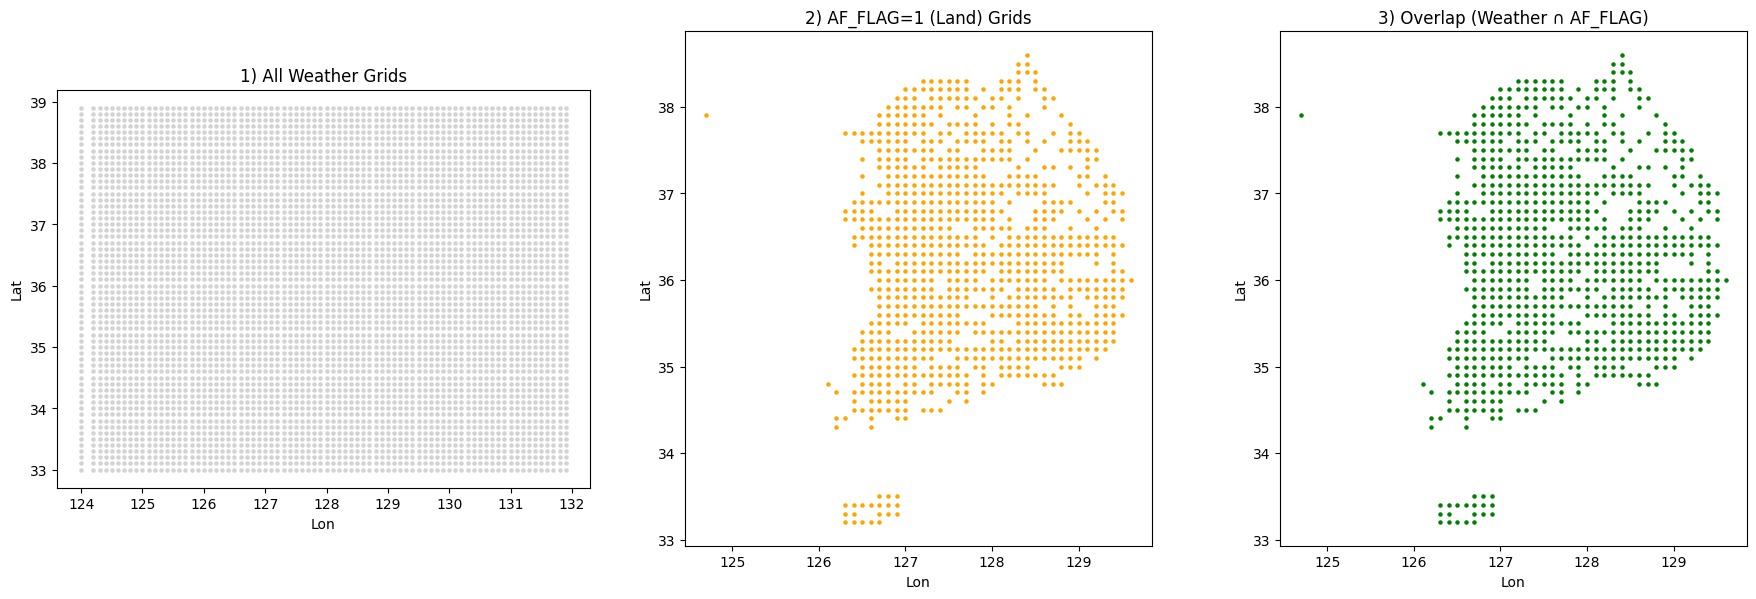

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 경로 설정 (실제 위치로 수정)
era_path = r'C:\Users\USER\Desktop\my_git\pof-model-korea\processed_data\era5_daily_combined_201901_202412.csv'
af_path  = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\af_flag\af_flag_full_combined.csv'

# 2) ERA5 그리드 로드 (위도/경도 포함)
df_era = pd.read_csv(
    era_path,
    usecols=['grid_id','longitude','latitude']
).drop_duplicates()

# 3) AF_FLAG에서 af_flag==1인 grid_id만 추출
df_af = pd.read_csv(af_path, usecols=['grid_id','af_flag'])
land_ids = df_af[df_af['af_flag']==1]['grid_id'].unique()

# 4) 각 집합 정의
#    (a) 전체 Weather 그리드
weather_all    = df_era

#    (b) AF_FLAG=1 그리드
af_land        = df_era[df_era['grid_id'].isin(land_ids)]

#    (c) 둘의 교집합 (사실 (b)가 (c)와 동일하지만, 일반화 차원에서 쓰임)
overlap        = af_land.copy()

# 5) 시각화: 3개 패널
fig, axes = plt.subplots(1, 3, figsize=(18,6))

axes[0].scatter(
    weather_all['longitude'],
    weather_all['latitude'],
    s=5, color='lightgrey'
)
axes[0].set_title('1) All Weather Grids')
axes[0].set_xlabel('Lon'); axes[0].set_ylabel('Lat')
axes[0].set_aspect('equal', 'box')

axes[1].scatter(
    af_land['longitude'],
    af_land['latitude'],
    s=5, color='orange'
)
axes[1].set_title('2) AF_FLAG=1 (Land) Grids')
axes[1].set_xlabel('Lon'); axes[1].set_ylabel('Lat')
axes[1].set_aspect('equal', 'box')

axes[2].scatter(
    overlap['longitude'],
    overlap['latitude'],
    s=5, color='green'
)
axes[2].set_title('3) Overlap (Weather ∩ AF_FLAG)')
axes[2].set_xlabel('Lon'); axes[2].set_ylabel('Lat')
axes[2].set_aspect('equal', 'box')

plt.tight_layout()
plt.show()



In [23]:
import pandas as pd

df = pd.read_csv(weather_path, parse_dates=['date'])
print(df['latitude'].min(), df['latitude'].max())
print(df['longitude'].min(), df['longitude'].max())
print(df['grid_id'].nunique())

33.0 38.90000000000008
124.0 131.89999999999955
4740


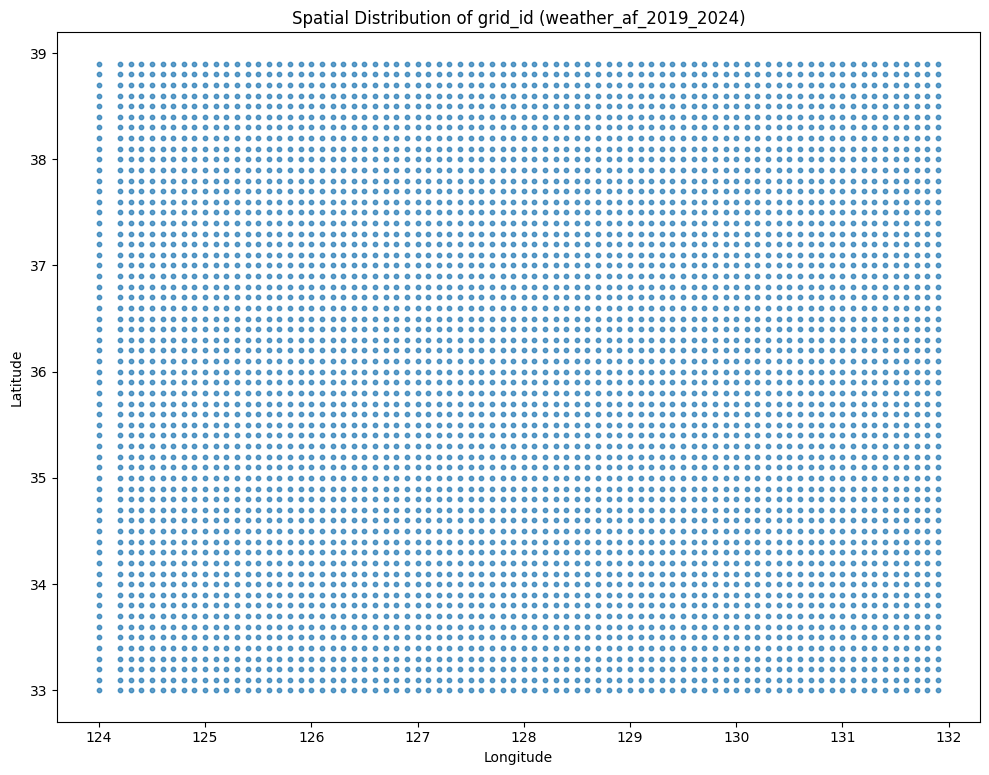

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 로컬 CSV 파일 경로 (사용자 환경에 맞게 수정하세요)
weather_path = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_2019_2024.csv'

# 1) 데이터 로드 및 고유 grid 위치 추출
df = pd.read_csv(weather_path)
grid_points = df[['grid_id', 'longitude', 'latitude']].drop_duplicates()

# 2) 산점도 그리기
plt.figure(figsize=(10, 8))
plt.scatter(
    grid_points['longitude'], 
    grid_points['latitude'], 
    s=10, 
    alpha=0.7
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of grid_id (weather_af_2019_2024)')
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# 1) 원본 데이터 로드 & date 컬럼 통일
road_path= r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.csv'
pop_path = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet'

# ERA5
df_era = pd.read_csv(era_path, parse_dates=['acq_date'])
df_era.rename(columns={'acq_date': 'date'}, inplace=True)

# AF_FLAG
df_af  = pd.read_csv(af_path, parse_dates=['date'])

# ROAD
df_rd  = pd.read_csv(road_path, parse_dates=['date'])

# POPULATION (Parquet)
df_pop = pd.read_parquet(pop_path)
# 만약 연도(year)컬럼만 있다면:
if 'year' in df_pop.columns and 'date' not in df_pop.columns:
    df_pop['date'] = pd.to_datetime(df_pop['year'].astype(str) + '-01-01')

# 2) 누락값·shape 확인 함수
def report(df, name):
    print(f'--- {name} ---')
    print('shape:', df.shape)
    print('nulls per column:')
    print(df.isnull().sum())
    print()

# join 전 리포트
report(df_era, 'ERA5')
report(df_af,  'AF_FLAG')
report(df_rd,  'ROAD')
report(df_pop, 'POP')

# 3) 순차적 inner merge
m1 = pd.merge(df_era, df_af,  on=['grid_id','date'], how='inner')
report(m1, 'ERA5 + AF')

m2 = pd.merge(m1,    df_rd,  on=['grid_id','date'], how='inner')
report(m2, 'ERA5+AF + ROAD')

m3 = pd.merge(m2,    df_pop, on=['grid_id','date'], how='inner')
report(m3, 'ERA5+AF+ROAD + POP')

# 4) (옵션) outer+indicator 로 키 매칭 현황 보기
for left_df, right_df, label in [
    (df_era, df_af,  'ERA5↔AF'),
    (m1,     df_rd,  'ERA5+AF↔ROAD'),
    (m2,     df_pop, 'ERA5+AF+ROAD↔POP')
]:
    tmp = pd.merge(left_df, right_df,
                   on=['grid_id','date'],
                   how='outer',
                   indicator=True)
    print(f'=== {label} key match ===')
    print(tmp['_merge'].value_counts(), '\n')

# 5) 결과 저장 (원하면)
m1.to_csv(r'…\era5_af_combined.csv', index=False)
m2.to_csv(r'…\era5_af_road_combined.csv', index=False)
m3.to_csv(r'…\all_data_combined.csv', index=False)



ValueError: Missing column provided to 'parse_dates': 'date'

In [15]:
import pandas as pd

# 파일 경로
weather_path = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_2019_2024.csv'
road_path    = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.csv'
pop_path     = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet'

# 1) Weather + AF 데이터 로드
weather = pd.read_csv(weather_path, parse_dates=['date'])
print('▶ Base weather_af shape:', weather.shape)

# 2) Road density 로드 & grid_id 기준으로 left join
road = pd.read_csv(road_path)
merged_rd = pd.merge(
    weather, road,
    on='grid_id',
    how='left'
)
print('▶ After road join shape:', merged_rd.shape)
print('  • road_dens 결측 건수:', merged_rd['road_dens'].isnull().sum(), '\n')

# 3) Population density 로드
pop = pd.read_parquet(pop_path)

# 만약 date 컬럼이 없고 year만 있을 경우 date 생성
if 'date' not in pop.columns and 'year' in pop.columns:
    pop['date'] = pd.to_datetime(pop['year'].astype(str) + '-01-01')
else:
    pop['date'] = pd.to_datetime(pop['date'])

# join에 사용할 pop 컬럼(예: 인구 밀도) 이름 확인
pop_cols = [c for c in pop.columns if c not in ['grid_id', 'year', 'date']]
print('▶ Population columns (excluding keys):', pop_cols)

# 4) grid_id + date 기준으로 left join
merged_full = pd.merge(
    merged_rd, pop,
    on=['grid_id', 'date'],
    how='left'
)
print('▶ After population join shape:', merged_full.shape)

# 5) 인구 밀도 컬럼별 결측값 확인
for col in pop_cols:
    print(f'  • {col} 결측 건수:', merged_full[col].isnull().sum())

# 6) 결과 저장
merged_full.to_csv(
    r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_road_pop_2019_2024.csv',
    index=False
)
print('\n▶ 최종 데이터가 저장되었습니다.')


▶ Base weather_af shape: (5442654, 11)
▶ After road join shape: (5442654, 12)
  • road_dens 결측 건수: 2795380 

▶ Population columns (excluding keys): ['value']
▶ After population join shape: (5442654, 13)
  • value 결측 건수: 5442654

▶ 최종 데이터가 저장되었습니다.


In [16]:
import pandas as pd

# 경로 설정
weather = pd.read_csv(weather_path, parse_dates=['date'])
road    = pd.read_csv(road_path)
pop     = pd.read_parquet(pop_path)

# (1) 고유 grid_id 개수
w_grids = set(weather['grid_id'].unique())
r_grids = set(road   ['grid_id'].unique())
p_grids = set(pop    ['grid_id'].unique())

print('weather grids:', len(w_grids))
print('road    grids:', len(r_grids))
print('pop     grids:', len(p_grids), '\n')

# (2) 교집합 크기
print('weather ∩ road :', len(w_grids & r_grids))
print('weather ∩ pop  :', len(w_grids & p_grids))
print('road    ∩ pop  :', len(r_grids & p_grids))


weather grids: 4740
road    grids: 2327
pop     grids: 2007 

weather ∩ road : 2305
weather ∩ pop  : 1992
road    ∩ pop  : 1985


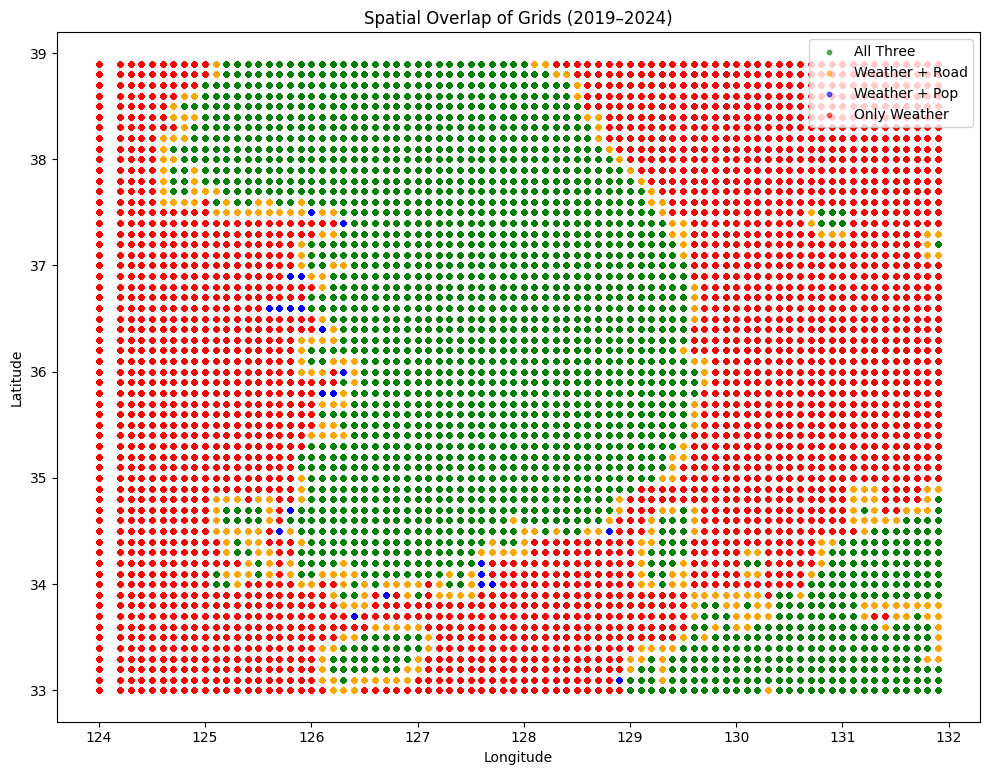

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 파일 경로 (실제 저장 경로를 확인해 주세요)
weather_path = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_road_pop_2019_2024.csv'
road_path    = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.csv'
pop_path     = r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet'

# 2) 데이터 로드
weather = pd.read_csv(weather_path, parse_dates=['date'])
road    = pd.read_csv(road_path)
pop     = pd.read_parquet(pop_path)

# 3) grid_id 존재 여부 집합 생성
road_grids = set(road['grid_id'])
pop_grids  = set(pop['grid_id'])

# 4) weather DataFrame에 카테고리 컬럼 추가
def categorize(g):
    in_r = g in road_grids
    in_p = g in pop_grids
    if in_r and in_p:
        return 'All Three'
    elif in_r:
        return 'Weather + Road'
    elif in_p:
        return 'Weather + Pop'
    else:
        return 'Only Weather'

weather['category'] = weather['grid_id'].apply(categorize)

# 5) 위도/경도 컬럼명 확인
#    (weather 파일에 이 컬럼들이 있어야 합니다)
lat_col = 'latitude'
lon_col = 'longitude'

# 6) 시각화
plt.figure(figsize=(10, 8))
categories = ['All Three', 'Weather + Road', 'Weather + Pop', 'Only Weather']
colors     = ['green',      'orange',         'blue',         'red']

for cat, color in zip(categories, colors):
    sub = weather[weather['category'] == cat]
    plt.scatter(
        sub[lon_col],
        sub[lat_col],
        label=cat,
        s=10,
        alpha=0.6,
        color=color
    )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Overlap of Grids (2019–2024)')
plt.legend(loc='upper right')
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()
